# Evaluate impact of max damges

In [232]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [233]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import bz2

sys.path.append('..')

from ruv.relative_utility_value import *
from ruv.damage_functions import *
from ruv.economic_models import *
from ruv.utility_functions import *
from ruv.helpers import *

In [234]:
plt.rcParams['figure.figsize'] = (8, 7)

plt.rcParams['font.family'] = "calibri"
plt.rcParams['font.size'] = "12.5"

colors = {
    'black': '#000000',
    'light_orange': '#E69F00',
    'light_blue': '#56B4E9',
    'green': '#009E73',
    'yellow': '#F0E442',
    'dark blue': '#0072B2',
    'dark_orange': '#D55E00',
    'pink': '#CC79A7'
} 

# Example forecast dataset
### Day 1 to 7 forecasts for catchment in southern Murray-Darling basin generated using the MuTHRE method

In [235]:
awrc = '405209'
dataset_filepath = '%s_data.pickle.bz2' % awrc
parallel_nodes = 8

max_damages_step = 0.1
max_damages_max_range = 20

target_risk_aversion = 0.3
target_risk_premium = risk_aversion_coef_to_risk_premium(target_risk_aversion, 1)  # target minor CARA aversion
print(target_risk_premium)

0.14780256641980102


In [236]:
with bz2.BZ2File(dataset_filepath, 'r') as f:
    data = pickle.load(f)
obs, clim_ens, fcst_ens = data['obs'], data['clim'], data['fcst']
print(obs.shape, fcst_ens.shape, clim_ens.shape)

(1932,) (1932, 100) (1932, 508)


# Define decision context

In [237]:
decision_definition = {
    'alphas': np.array([0.2]), # [0.1, 0.5, 0.9]),
    'economic_model': [cost_loss, cost_loss_analytical_spend],
    'decision_thresholds': None,
    'decision_method': 'optimise_over_forecast_distribution',
    'damage_function': [logistic, {'k': 1, 'A':1, 'threshold': np.nanquantile(obs, 0.99)}]
}

ref = clim_ens  # use 14-day moving average climatology as the reference forecast

# Plot sample damage functions

In [238]:
As = np.arange(max_damages_step, max_damages_max_range, max_damages_step)

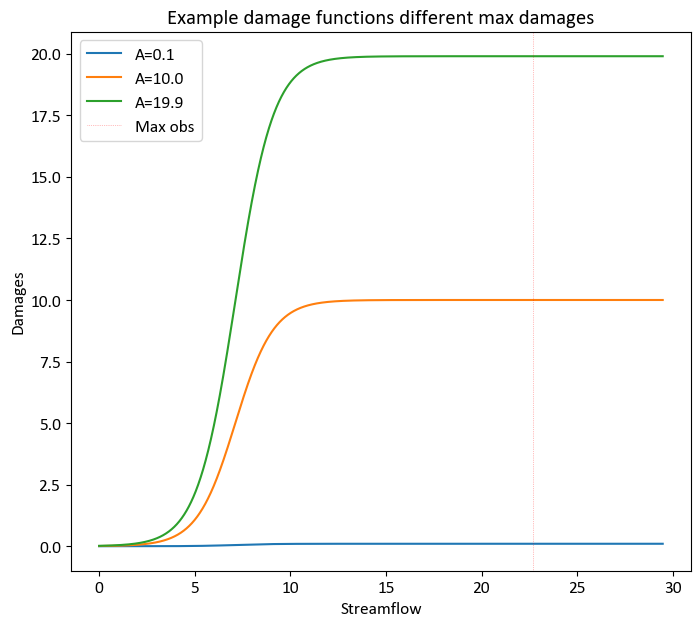

In [239]:
streamflow = np.arange(0, np.nanmax(obs) * 1.3, 0.01)
damage_fnc, params = decision_definition['damage_function']

for A in As[[0, int(len(As)/2), len(As)-1]]:
    params['A'] = A
    damages = damage_fnc(params)(streamflow)
    plt.plot(streamflow, damages, label='A=%.1f' % params['A'])

plt.axvline(np.nanmax(obs), color='red', linewidth=0.5, alpha=0.5, linestyle='dotted', label='Max obs')

plt.title('Example damage functions different max damages')
plt.xlabel('Streamflow')
plt.ylabel('Damages')
plt.legend()

# Calculate RUV for the different shape logistic damage functions

In [240]:
results_unadjusted = {}
results_adjusted = {}
for A in As:
    decision_definition['damage_function'] = [logistic, {'k': 1, 'A': A, 'threshold': np.nanquantile(obs, 0.99)}]

    decision_definition['utility_function'] = [cara, {'A': target_risk_aversion}]
    results_unadjusted[A] = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes=parallel_nodes)['ruv']

    adjusted_risk_aversion = risk_premium_to_risk_aversion_coef(target_risk_premium, A)
    decision_definition['utility_function'] = [cara, {'A': adjusted_risk_aversion}]
    results_adjusted[A] = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes=parallel_nodes)['ruv']

results_adjusted_df = pd.DataFrame(results_adjusted, index=decision_definition['alphas']).T
results_unadjusted_df = pd.DataFrame(results_unadjusted, index=decision_definition['alphas']).T

c:\Users\me\research\relative-utility-value\examples\..\ruv\helpers.py:49: RuntimeWarning: overflow encountered in exp
  return np.log(0.5 * (np.exp(-A * gamble_size) + np.exp(A * gamble_size))) / (A * gamble_size) - risk_premium


# Plot results for different values of alpha

In [241]:
results = results_adjusted_df.join(results_unadjusted_df, lsuffix='_adjusted', rsuffix='_unadjusted')

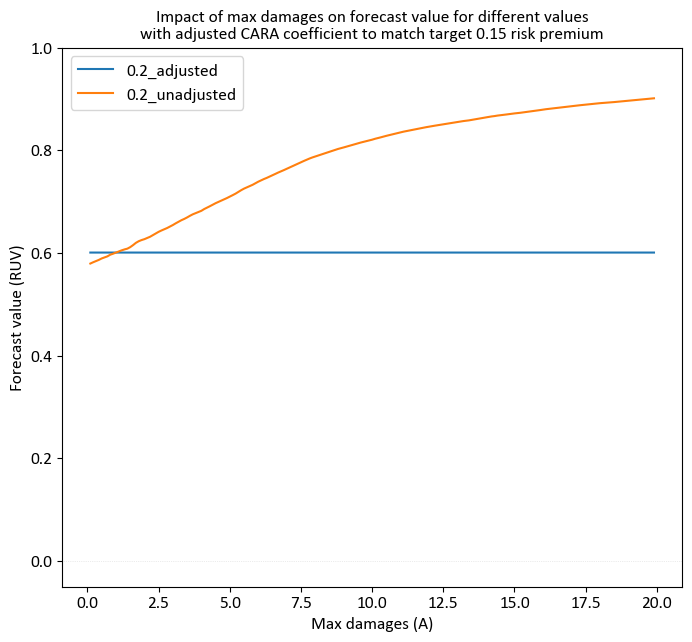

In [242]:
results.plot()

plt.axhline(0, color='grey', linewidth=0.5, alpha=0.3, linestyle='dotted')
plt.ylim(-0.05, 1)
#plt.xlim((0, 4.5))

plt.xlabel('Max damages (A)')
plt.ylabel('Forecast value (RUV)')
plt.title('Impact of max damages on forecast value for different values\nwith adjusted CARA coefficient to match target 0.15 risk premium', fontsize='medium')
plt.legend()